# CLS Vector Analysis IMDB Dataset 

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, pickle, sys, warnings, itertools, re
warnings.filterwarnings(action='ignore')
sys.path.insert(0, '../scripts')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

import datasets, pysbd, spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
from config import project_dir
from config import data_params as dp
from config import model_params as mp

from utils import clean_text, extract_result, reduce_dim
from plot_tools import plot_scree, plot2d_comps
from model import IMDBClassifier

In [3]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoTokenizer

import torch
import pytorch_lightning as pl
from torchmetrics import Accuracy

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.decomposition import PCA
from sklearn import preprocessing

from transformers import AutoModelForSequenceClassification, AdamW

## Load cleaned Data

In [4]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'  
try:
  dsd_clean = datasets.load_from_disk(data_dir_main)
except FileNotFoundError:
  dsd = datasets.load_dataset('imdb')
  dsd = dsd.rename_column('label', 'labels')
  dsd_clean = dsd.map(clean_text)
  dsd_clean.save_to_disk(data_dir_main)

mp.model_dir = project_dir/'models'/dp.dataset_name/'unpoisoned'/mp.model_name  

## Model Testing & CLS Vectors

In [5]:
train_ds,test_ds = dsd_clean['train'],dsd_clean['test']
# train_ds = train_ds.shuffle(seed=42).select(range(64))
# test_ds = test_ds.shuffle(seed=42).select(range(64))
# train_ds, test_ds

In [6]:
try:
  with open(mp.model_dir/'version_0/train_cls_vectors.npy', 'rb') as f:
    train_cls = np.load(f)  
  with open(mp.model_dir/'version_0/test_cls_vectors.npy', 'rb') as f:
    test_cls = np.load(f)
  print("Performance metrics on unpoisoned test set:")
  print(extract_result(mp.model_dir/'version_0/test_metrics.pkl'))  
except FileNotFoundError:
  with open(mp.model_dir/'version_0/best.path', 'r') as f:
    model_path = f.read().strip()
  tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

  train_ds = train_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  train_dl = DataLoader(train_ds, batch_size=dp.batch_size)
  
  test_ds = test_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_dl = DataLoader(test_ds, batch_size=dp.batch_size) 
  
  csv_logger = CSVLogger(save_dir=mp.model_dir, name=None, version=0)
  trainer = pl.Trainer(gpus=1, logger=csv_logger, checkpoint_callback=False)  
  
  mp.mode_prefix = 'train'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)
  trainer.test(clf_model, dataloaders=train_dl)
  
  mp.mode_prefix = 'test'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)  
  result = trainer.test(clf_model, dataloaders=test_dl)

  print("Performance metrics on unpoisoned test set:")
  print(extract_result(result))

Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis_dp/new_expts/datasets/imdb/cleaned/train/cache-a740037ec06aaee1.arrow
Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis_dp/new_expts/datasets/imdb/cleaned/test/cache-af95767895525452.arrow
/net/kdinxidk03/opt/NFS/su0/anaconda3/envs/dp/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassificat

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy                  0.98248
           f1               0.9823983282430477
        precision           0.9869993540051679
         recall                   0.97784
        test_loss          0.061053384095430374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy                  0.9316
           f1               0.9309593023255814
        precision           0.9397619823932182
         recall                   0.92232
        test_loss           0.21407030522823334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance metrics on unpoisoned test set:
Accuracy: 93.16%
Recall: 92.23%
Precision: 93.98%
F1: 93.10%



## PCA Analysis

In [7]:
with open(mp.model_dir/'version_0/train_cls_vectors.npy', 'rb') as f:
  train_cls = np.load(f)  
with open(mp.model_dir/'version_0/test_cls_vectors.npy', 'rb') as f:
  test_cls = np.load(f)

train_df,test_df = dsd_clean['train'].to_pandas(),dsd_clean['test'].to_pandas()

In [8]:
pca_train, pca_train_cls = reduce_dim(train_cls, method='pca', n_comp=None, scale=True)
pca_test, pca_test_cls = reduce_dim(test_cls, method='pca', n_comp=None, scale=True)

In [9]:
n_comps = 10

pca_train_df = pd.DataFrame(data=pca_train_cls[:, :n_comps], columns=[f'{comp+1}' for comp in range(n_comps)])
pca_train_df['labels'] = train_df['labels']

pca_test_df = pd.DataFrame(data=pca_test_cls[:, :n_comps], columns=[f'{comp+1}' for comp in range(n_comps)])
pca_test_df['labels'] = test_df['labels']

In [10]:
per_var_train = np.round(pca_train.explained_variance_ratio_ * 100, decimals=3)
labels_train = [str(x) for x in range(len(per_var_train))]

per_var_test = np.round(pca_test.explained_variance_ratio_ * 100, decimals=3)
labels_test = [str(x) for x in range(len(per_var_test))]

### Plots

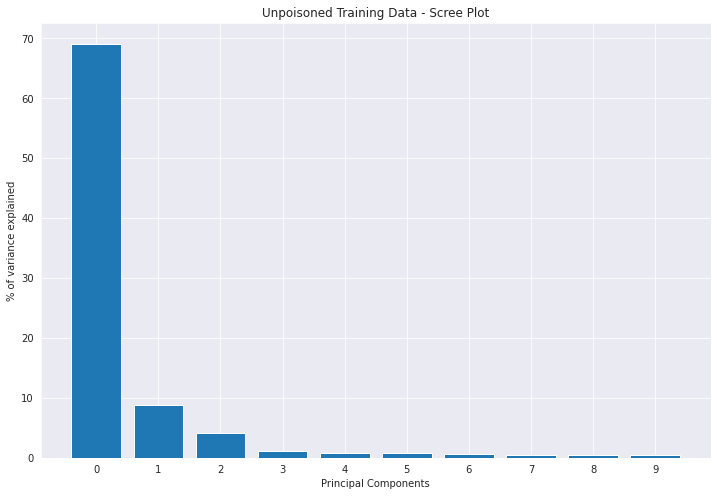

In [11]:
plot_scree(per_var_train, labels_train, title='Unpoisoned Training Data - Scree Plot', n_comps=10)

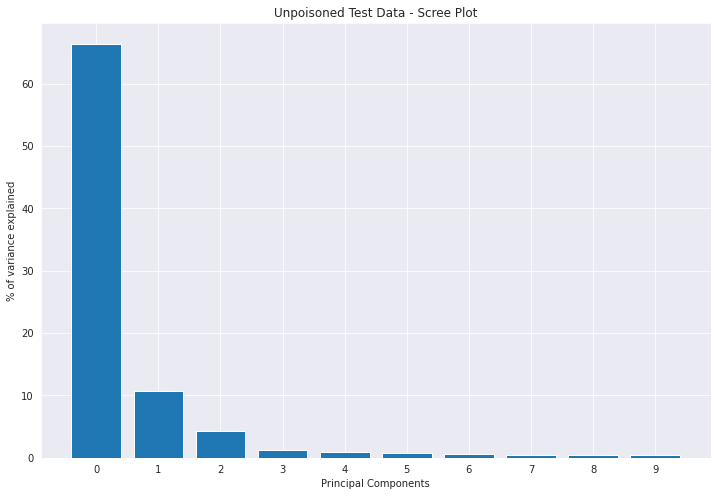

In [12]:
plot_scree(per_var_test, labels_test, title='Unpoisoned Test Data - Scree Plot', n_comps=10)

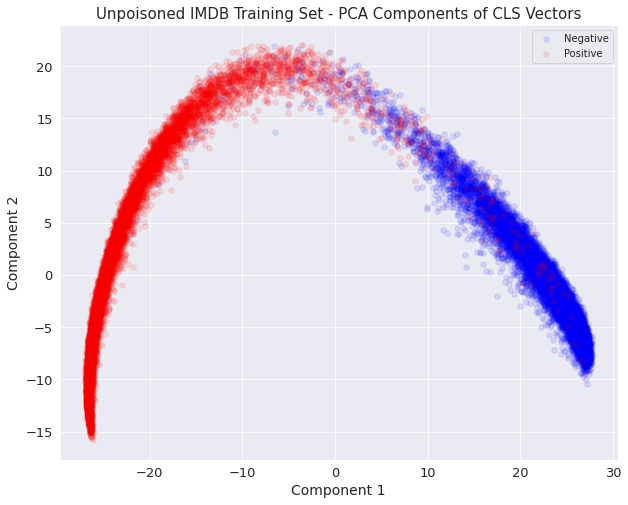

In [13]:
plot2d_comps(pca_train_df, "Unpoisoned IMDB Training Set - PCA Components of CLS Vectors")

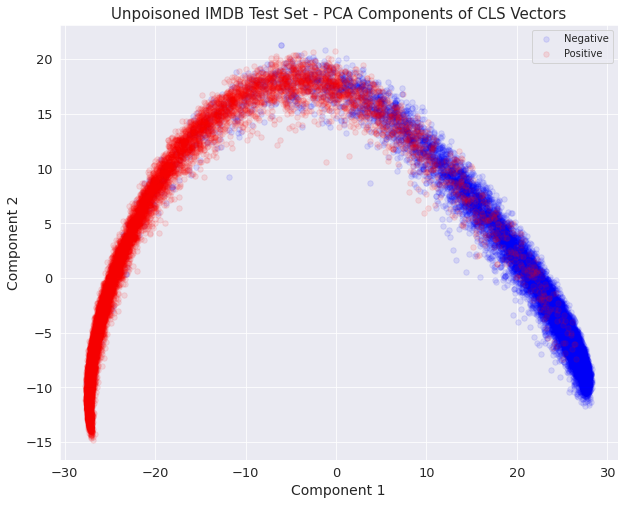

In [14]:
plot2d_comps(pca_test_df, "Unpoisoned IMDB Test Set - PCA Components of CLS Vectors")

### Logistic Regression

In [ ]:
n_comps = 2
train2d_df = pd.DataFrame(data=pca_train_cls[:, :n_comps], columns=[f'c{comp+1}' for comp in range(n_comps)])
train2d_df['labels'] = train_df['labels']

test2d_df = pd.DataFrame(data=pca_test_cls[:, :n_comps], columns=[f'c{comp+1}' for comp in range(n_comps)])
test2d_df['labels'] = test_df['labels']

In [ ]:
clf = LogisticRegression(random_state=0).fit(train2d_df[['c1', 'c2']], train2d_df['labels'])

In [ ]:
preds = clf.predict(test2d_df[['c1', 'c2']])